<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_2_1_MLP_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [14]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
psutil.virtual_memory()

15.5


svmem(total=13653585920, available=12534697984, percent=8.2, used=1182285824, free=10000961536, active=944721920, inactive=2421342208, buffers=99786752, cached=2370551808, shared=954368, slab=174030848)

In [4]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
# Preprocessing
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Machine learning algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Metrics
from imblearn.metrics import geometric_mean_score
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow import feature_column  # for data wrangling
from tensorboard.plugins.hparams import api as hp

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

2.3.0


In [5]:
# Download dataset
url = 'https://github.com/duonghung86/Injury-severity-classification/blob/main/Prepared%20Texas%202019.zip?raw=true' 
tf.keras.utils.get_file(origin=url, fname=url.split('/')[-1], extract=True)
data_path = '/root/.keras/datasets/' + url.split('/')[-1].split('?')[0].replace('%20',' ').replace('.zip','.csv')

10592256/10587626 [==============================] - 0s 0us/step


In [6]:
# Load data
df = pd.read_csv(data_path)
print(df.shape)
df.head(3)

(949856, 19)


,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN


In [7]:
# Let's just use 80% of the total dataset
df, _ = train_test_split(df, test_size=0.9,stratify = df['Prsn_Injry_Sev'])
df.shape

(94985, 19)

In [8]:
y = df['Prsn_Injry_Sev']
print('All target values:')
print(y.value_counts())
X = df.drop(columns=['Prsn_Injry_Sev'])

All target values:
0    79255
1    10241
2     4524
3      795
4      170
Name: Prsn_Injry_Sev, dtype: int64


In [9]:
# %% Data wrangling -------------
# Classify variable type
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique()) > 5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ', num_vars)
print('Categorical variables that have at most 5 categories are ', ind_vars)
print('Categorical variables that have more than 5 categories are ', emb_vars)

# Create feature columns
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header))
# bucketized cols
# age = feature_column.numeric_column('Prsn_Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
# feature_columns.append(age_buckets)
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

# Convert all setup into new dataset
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
print('New shape of the input data set:',X.shape)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']
New shape of the input data set: (94985, 59)


In [10]:
# %% Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

# %% standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training features shape: (60790, 59)
Validation features shape: (15198, 59)
Test features shape: (18997, 59)


# Resampling


In [11]:
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss,EditedNearestNeighbours

In [12]:
y_dict = Counter(y_train)
y_dict

Counter({0: 50723, 1: 6554, 2: 2895, 3: 509, 4: 109})

In [13]:
ss = {}
for i in range(2,5):
    ss[i] = y_dict[1]
oses = {'ROS':             RandomOverSampler(sampling_strategy=ss), 
        'SMOTE':           SMOTE(sampling_strategy=ss),
     #   'BorderlineSMOTE': BorderlineSMOTE(sampling_strategy=ss)
        }
uses = {'RUS':                      RandomUnderSampler(sampling_strategy='majority'), 
        'NearMiss':                 NearMiss(sampling_strategy='majority'),
    #    'EditedNearestNeighbours':  EditedNearestNeighbours(sampling_strategy='majority')
        }

In [29]:
['Overall Accuracy','G-mean']+['Avg_Pfm','Training Time']

['Overall Accuracy', 'G-mean', 'Avg_Pfm', 'Training Time']

In [33]:
# %% Function to compare the prediction and true labels
def get_accs(label, prediction, tr_time,  show=True):
    cm = confusion_matrix(label, prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm) / len(label)
    ind_accs = cm / np.sum(cm, axis=1)[:, np.newaxis]
    accs = [ind_accs[i, i] for i in range(length)]
    index = ['Class {}'.format(i) for i in range(length)]
    # Global accuracy
    accs.append(glb_acc)
    #index.append
    # G-mean
    accs.append(geometric_mean_score(label, prediction, correction=0.001))
    #index.append('G-mean')
    # Average perf
    accs.append((glb_acc + accs[-1]) / 2)
    #index.append('Avg_Pfm')
    # Training time
    accs.append(np.round(tr_time,3))
    index = index + ['Overall Accuracy','G-mean','Avg_Pfm','Training Time']
    # Plot confusion matrix
    plot_dict = {'Confusion matrix': (cm,'g'),
                 'Normalized confusion matrix': (ind_accs,'.2f')}
    if show:
        plt.figure(figsize=(14, 6))
        i = 1
        for key, value in plot_dict.items():
            plt.subplot(1, 2, i)
            sns.heatmap(value[0], xticklabels=np.arange(length), yticklabels=np.arange(length),
                        annot=True, fmt=value[1], cmap="YlGnBu")
            plt.xlabel('Prediction')
            plt.ylabel('Label')
            plt.title(key)
            i+= 1
        plt.show()
    out = np.array(accs).reshape(1, len(accs))
    return pd.DataFrame(out, columns=index)

ROS - RUS
Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 6554, 3: 6554, 4: 6554})
Resamling time 0.068524 sec


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGI

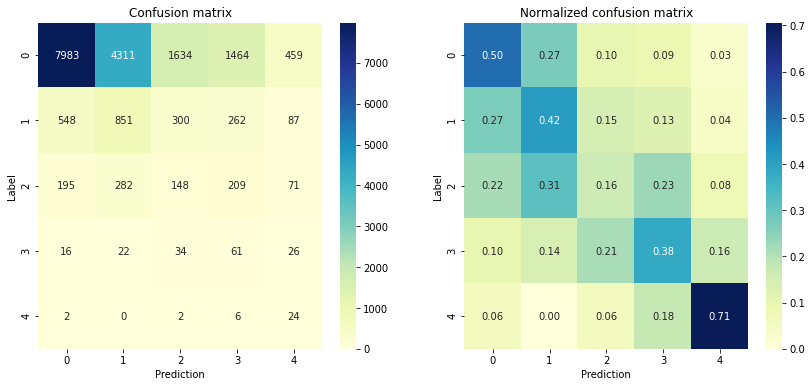

ROS - NearMiss


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 6554, 3: 6554, 4: 6554})
Resamling time 32.370257 sec


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


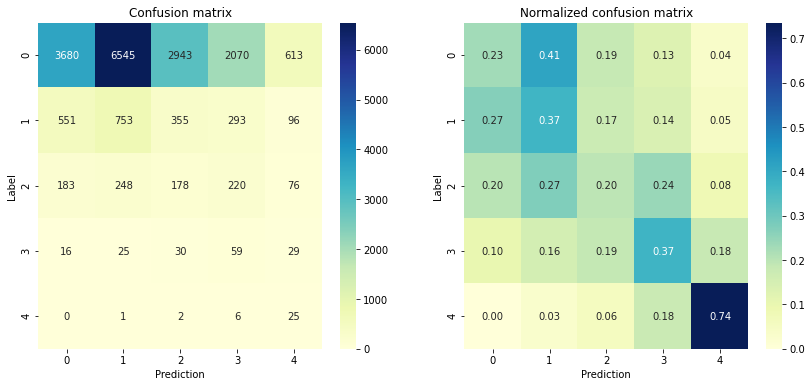

SMOTE - RUS


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 6554, 3: 6554, 4: 6554})
Resamling time 1.120126 sec


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


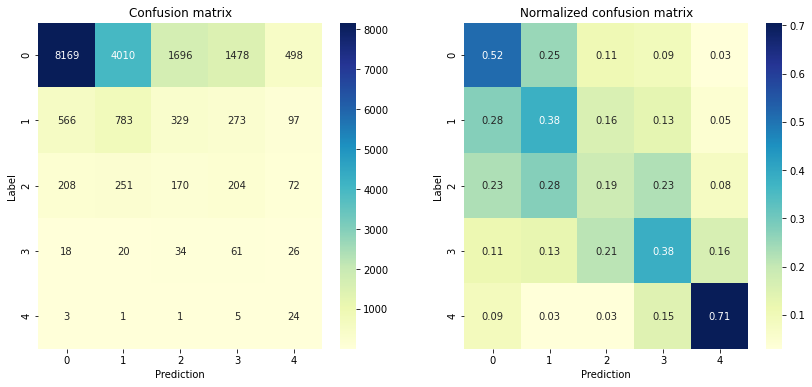

SMOTE - NearMiss


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
rsts = pd.DataFrame()
for os_name, os_sampler in oses.items():
    for us_name, us_sampler in uses.items():
        print(os_name,'-',us_name)
        start = time.time()
        res = os_sampler
        X_res, y_res = res.fit_resample(X_train, y_train)

        res = us_sampler
        X_res, y_res = res.fit_resample(X_res, y_res)
        end = time.time()
        print('Resampled dataset shape %s' % Counter(y_res))
        print('Resamling time %f sec' % (end-start))
        LR = LogisticRegression(solver = 'lbfgs',class_weight= 'balanced')
        start = time.time()
        LR.fit(X_res, y_res)
        end= time.time()
        # get the evaluation metrics
        # use the model to make predictions with the test data
        y_pred = LR.predict(X_test)
        result = get_accs(y_test.values,y_pred, tr_time= end-start,show= True)
        result.index = ['LR-' + os_name + '-' + us_name]
        rsts = rsts.append(result)
rsts

In [ ]:
# OS and then US
ss = {}
for i in range(2,5):
    ss[i] = 6554

rus = RandomOverSampler(random_state=42,sampling_strategy=ss)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
X_res, y_res = rus.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 50723, 1: 6554, 3: 6554, 2: 6554, 4: 6554})
Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 6554, 3: 6554, 4: 6554})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def os4us(sampler1, sample2):
    ss = {}
    for i in range(2,5):
        ss[i] = y_dict[1]
    start = time.time()
    rus = sampler1(sampling_strategy=ss)
    X_res, y_res = rus.fit_resample(X_train, y_train)

    rus = sampler2(sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(X_res, y_res)
    end = time.time()
    print('Resampled dataset shape %s' % Counter(y_res))
    print('Resamling time %f' % (start-end))


In [ ]:
# US and then OS
ss = {}
for i in range(1):
    ss[i] = 6554

rus = RandomUnderSampler(random_state=42,sampling_strategy=ss)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

rus = RandomOverSampler(random_state=42,sampling_strategy='not majority')
X_res, y_res = rus.fit_resample(X_res, y_res)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 2895, 3: 509, 4: 109})
Resampled dataset shape Counter({0: 6554, 1: 6554, 2: 6554, 3: 6554, 4: 6554})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
ss = {}
for i in range(5):
    ss[i] = 6554

rus = RandomUnderSampler(random_state=42,sampling_strategy=ss)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

ValueError: ignored

In [ ]:
for ss in ['minority', 'not minority','not majority', 'all']:
    res = RandomOverSampler(random_state=42,sampling_strategy=ss)
    X_res, y_res = res.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({0: 50723, 4: 50723, 1: 6554, 2: 2895, 3: 509})
Resampled dataset shape Counter({0: 50723, 1: 50723, 3: 50723, 2: 50723, 4: 109})
Resampled dataset shape Counter({0: 50723, 1: 50723, 3: 50723, 2: 50723, 4: 50723})
Resampled dataset shape Counter({0: 50723, 1: 50723, 3: 50723, 2: 50723, 4: 50723})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 6554, 2: 2895, 3: 509, 0: 109, 4: 109})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ros
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 0.51 seconds
Epoch 1/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4699 - cohen_kappa: 0.2563 - val_loss: 1.4329 - val_cohen_kappa: 0.0779
Epoch 2/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.4572 - cohen_kappa: 0.2725 - val_loss: 1.4340 - val_cohen_kappa: 0.0793
Epoch 3/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4560 - cohen_kappa: 0.2739 - val_loss: 1.4197 - val_cohen_kappa: 0.0794
Epoch 4/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4550 - cohen_kappa: 0.2746 - val_loss: 1.3992 - val_cohen_kappa: 0.0888
Epoch 5/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4549 - cohen_kappa: 0.2750 - val_loss: 1.3997 - val_cohen_kappa: 0.0906
Epoch 6/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4550 - cohen_kappa: 0.2751 - 

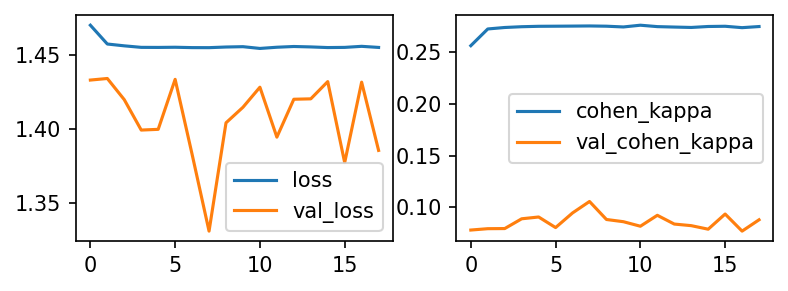

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

SMOTE
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 404.29 seconds
Epoch 1/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.4601 - cohen_kappa: 0.2662 - val_loss: 1.4067 - val_cohen_kappa: 0.0813
Epoch 2/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.4543 - cohen_kappa: 0.2731 - val_loss: 1.4063 - val_cohen_kappa: 0.0834
Epoch 3/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4531 - cohen_kappa: 0.2747 - val_loss: 1.4108 - val_cohen_kappa: 0.0792
Epoch 4/50
63405/63405 [==============================] - 88s 1ms/step - loss: 1.4526 - cohen_kappa: 0.2754 - val_loss: 1.3980 - val_cohen_kappa: 0.0869
Epoch 5/50
63405/63405 [==============================] - 83s 1ms/step - loss: 1.4523 - cohen_kappa: 0.2755 - val_loss: 1.4151 - val_cohen_kappa: 0.0832
Epoch 6/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4522 - cohen_kappa: 0.276

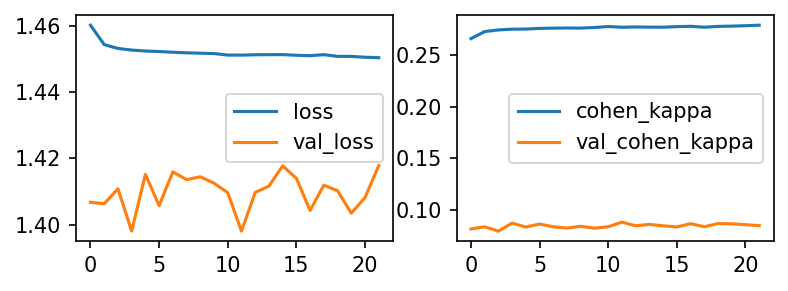

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

BorderlineSMOTE
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 9932.27 seconds
Epoch 1/50
63405/63405 [==============================] - 88s 1ms/step - loss: 1.3892 - cohen_kappa: 0.3748 - val_loss: 1.3523 - val_cohen_kappa: 0.0957
Epoch 2/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.3769 - cohen_kappa: 0.3912 - val_loss: 1.3432 - val_cohen_kappa: 0.1029
Epoch 3/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.3752 - cohen_kappa: 0.3935 - val_loss: 1.3334 - val_cohen_kappa: 0.1042
Epoch 4/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.3737 - cohen_kappa: 0.3960 - val_loss: 1.3526 - val_cohen_kappa: 0.1001
Epoch 5/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.3728 - cohen_kappa: 0.3970 - val_loss: 1.3473 - val_cohen_kappa: 0.1009
Epoch 6/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.3723 - cohen_k

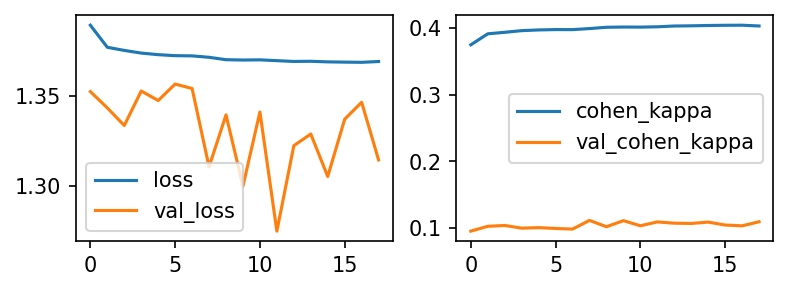

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RUS
Resampled dataset shape Counter({0: 869, 1: 869, 2: 869, 3: 869, 4: 869})
resampling time is 0.22 seconds
Epoch 1/50
136/136 [==============================] - 4s 29ms/step - loss: 1.6256 - cohen_kappa: 0.0109 - val_loss: 1.5847 - val_cohen_kappa: 0.0135
Epoch 2/50
136/136 [==============================] - 4s 27ms/step - loss: 1.6034 - cohen_kappa: 0.0411 - val_loss: 1.5752 - val_cohen_kappa: 0.0222
Epoch 3/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5925 - cohen_kappa: 0.0791 - val_loss: 1.5399 - val_cohen_kappa: 0.0464
Epoch 4/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5722 - cohen_kappa: 0.1438 - val_loss: 1.5134 - val_cohen_kappa: 0.0577
Epoch 5/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5544 - cohen_kappa: 0.1732 - val_loss: 1.4734 - val_cohen_kappa: 0.0699
Epoch 6/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5443 - cohen_kappa: 0.1787 - val_loss: 1.4561 - val_cohen_kappa: 0.0

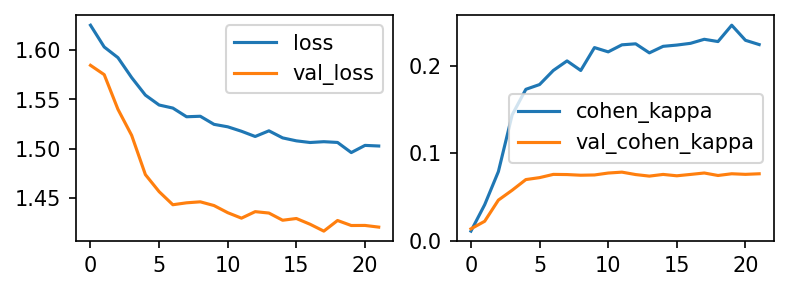

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss
Resampled dataset shape Counter({0: 869, 1: 869, 2: 869, 3: 869, 4: 869})
resampling time is 33.98 seconds
Epoch 1/50
136/136 [==============================] - 5s 35ms/step - loss: 1.6088 - cohen_kappa: 0.0503 - val_loss: 1.5480 - val_cohen_kappa: 0.0217
Epoch 2/50
136/136 [==============================] - 4s 33ms/step - loss: 1.5241 - cohen_kappa: 0.1948 - val_loss: 1.5626 - val_cohen_kappa: 0.0285
Epoch 3/50
136/136 [==============================] - 4s 32ms/step - loss: 1.4934 - cohen_kappa: 0.2261 - val_loss: 1.5853 - val_cohen_kappa: 0.0274
Epoch 4/50
136/136 [==============================] - 5s 33ms/step - loss: 1.4814 - cohen_kappa: 0.2471 - val_loss: 1.5940 - val_cohen_kappa: 0.0275
Epoch 5/50
136/136 [==============================] - 4s 32ms/step - loss: 1.4685 - cohen_kappa: 0.2629 - val_loss: 1.6107 - val_cohen_kappa: 0.0248
Epoch 6/50
136/136 [==============================] - 4s 27ms/step - loss: 1.4640 - cohen_kappa: 0.2742 - val_loss: 1.6213 - val_cohen_kapp

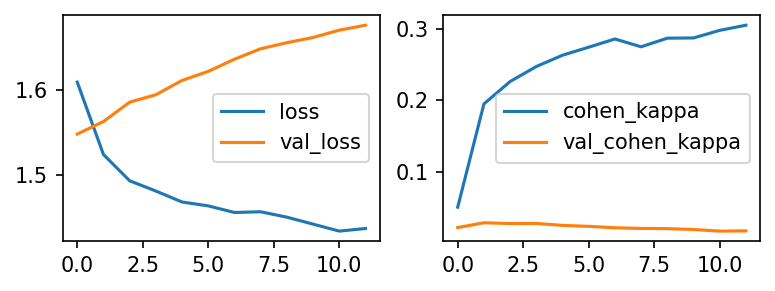

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.513544,0.399548,0.137864,0.341981,0.634686,0.482139,0.361104,0.421621,33.938
DT,0.829026,0.142500,0.081641,0.063679,0.180812,0.711845,0.161846,0.436846,16.501
RF,0.634955,0.333394,0.028181,0.231132,0.738007,0.570343,0.252066,0.411205,43.834
MLP accuracy,0.547209,0.292506,0.212184,0.320755,0.605166,0.501997,0.366277,0.434137,416.384
MLP cohen_kappa,0.563730,0.310448,0.155961,0.420597,0.568266,0.515808,0.365509,0.440659,717.956
MLP f1_score,0.477529,0.492677,0.055394,0.281447,0.675277,0.457767,0.301149,0.379458,259.346
MLP with Cohen Kappa,0.477529,0.492677,0.055394,0.281447,0.675277,0.457767,0.301149,0.379458,259.346
MLP ros,0.673824,0.245209,0.128747,0.385220,0.579336,0.599064,0.342998,0.471031,1451.463
MLP SMOTE,0.490659,0.472782,0.115900,0.240566,0.726937,0.469209,0.342335,0.405772,2216.447
MLP BorderlineSMOTE,0.581441,0.415782,0.215638,0.335692,0.350554,0.543688,0.361042,0.452365,11417.054


In [ ]:
Resamples = {'ros':             RandomOverSampler(), 
             'SMOTE':           SMOTE(random_state=42),
             'BorderlineSMOTE': BorderlineSMOTE(),
             'RUS': RandomUnderSampler(), 
             'NearMiss': NearMiss()
             }
for key,value in Resamples.items():
    start = time.time()
    X_res, y_res = value.fit_resample(X_train, y_train)
    end = time.time()
    resampling_time = end - start
    print(key)
    print('Resampled dataset shape %s' % Counter(y_res))
    print('resampling time is {0:.2f} seconds'.format(end-start))
    model = create_mlp(CohenKappa(num_classes=5,sparse_labels=True))
    start = time.time()
    monitor = model.fit(X_res, y_res,
                        callbacks=[early_stops('cohen_kappa')],
                        validation_data=(X_val, y_val.values),
                        verbose=1, epochs=50)
    end = time.time()
    #print(evaluation(model, monitor, end - start, 'MLP '+key))
    rsts = rsts.append(evaluation(model, monitor, end - start + resampling_time, 'MLP '+key))
rsts

# ALL mini functions



In [ ]:


def show_evolution(moni):
    hist = pd.DataFrame(monitor.history)
    no_metrics = np.int(hist.shape[1]/2)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), dpi=150)
    for i in range(2):
      hist.iloc[:,[i,no_metrics+i]].plot(ax=axes[i])
    plt.show()
# %% Produce an evaluation on the MLP model
def evaluation(model, monitor, time, name):
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    # Show evolution of the training process
    show_evolution(monitor)
    # get the evaluation metrics
    result = get_accs(y_test.values, y_pred, False)
    result['Training Time'] = np.round(time, 3)
    result.index = [name]
    return result

LR


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


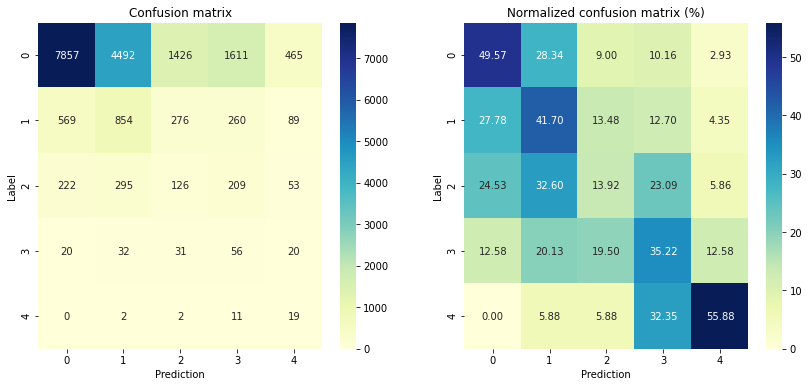

DT


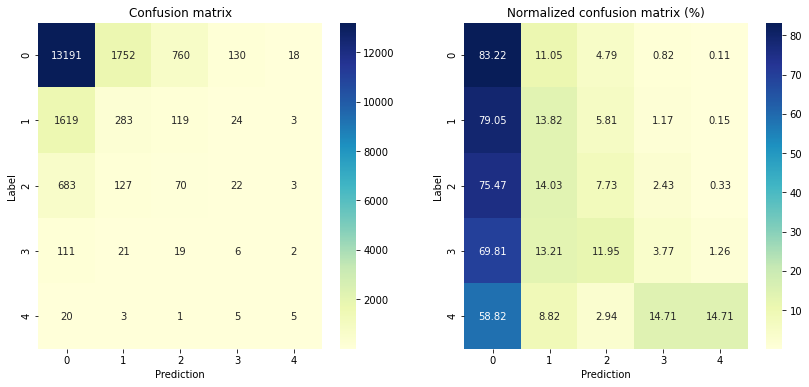

RF


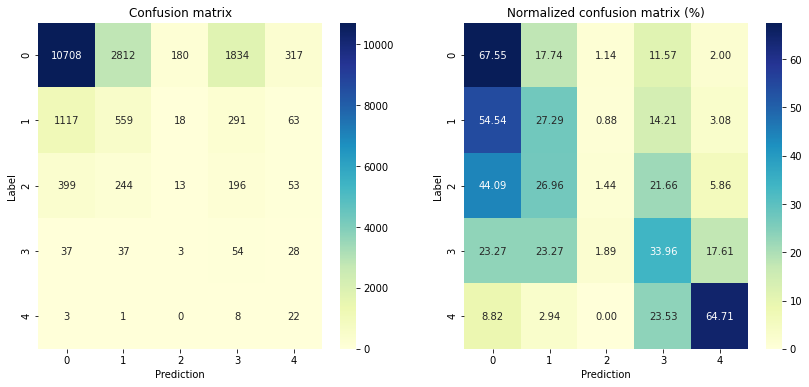

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.495679,0.416992,0.139227,0.352201,0.558824,0.469127,0.355323,0.412225,5.671
DT,0.832187,0.138184,0.077348,0.037736,0.147059,0.713534,0.137618,0.425576,1.216
RF,0.675541,0.272949,0.014365,0.339623,0.647059,0.597779,0.225421,0.411600,3.575


In [ ]:
wgt='balanced'
clfs = [LogisticRegression(solver = 'lbfgs',class_weight=wgt),
        DecisionTreeClassifier(class_weight=wgt),
        RandomForestClassifier(max_depth=4,class_weight=wgt)]
clf_names = ['LR','DT','RF']
rsts = pd.DataFrame()
for model, name in zip(clfs,clf_names):
    start = time.time()
    print(name)
    model.fit(X_train, y_train.values)
    # use the model to make predictions with the test data
    y_pred = model.predict(X_test)
    end= time.time()
    # get the evaluation metrics
    result = get_accs(y_test.values,y_pred,True)
    result['Training Time'] = np.round(end-start,3)
    result.index = [name]
    rsts = rsts.append(result)
rsts

# MLP functions


In [ ]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import CohenKappa,F1Score

In [ ]:
# Add weights
weights = len(y) / (5 * np.bincount(y))
cls_wgt = dict(zip(np.arange(5), weights))
cls_wgt

{0: 0.23969465648854962,
 1: 1.8549946294307196,
 2: 4.199160035366932,
 3: 23.89559748427673,
 4: 111.74705882352941}

In [ ]:
def early_stops(metric_name):
    es = EarlyStopping(monitor='val_'+ metric_name,
                   verbose=1,
                   patience=10,
                   mode='max',
                   restore_best_weights=True)
    return es

# Ordinal multiclass


In [ ]:
early_stop = {'accuracy':  tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
              'cohen_kappa': CohenKappa(num_classes=5,sparse_labels=True),
              'f1_score': F1Score(num_classes=5,average="micro",threshold=0.5),
               }

In [ ]:
def create_mlp(metric):
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1]
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[metric]
               )
    return MLP

Epoch 1/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.6025 - accuracy: 0.2974 - val_loss: 1.4927 - val_accuracy: 0.4648
Epoch 2/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5521 - accuracy: 0.3805 - val_loss: 1.4643 - val_accuracy: 0.4943
Epoch 3/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5201 - accuracy: 0.3481 - val_loss: 1.4375 - val_accuracy: 0.5126
Epoch 4/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5107 - accuracy: 0.3648 - val_loss: 1.4698 - val_accuracy: 0.4372
Epoch 5/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5006 - accuracy: 0.3430 - val_loss: 1.4309 - val_accuracy: 0.5139
Epoch 6/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4947 - accuracy: 0.3652 - val_loss: 1.4620 - val_accuracy: 0.4418
Epoch 7/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4843 - accuracy: 0.3750 - val_loss: 1.4397 - val_accuracy:

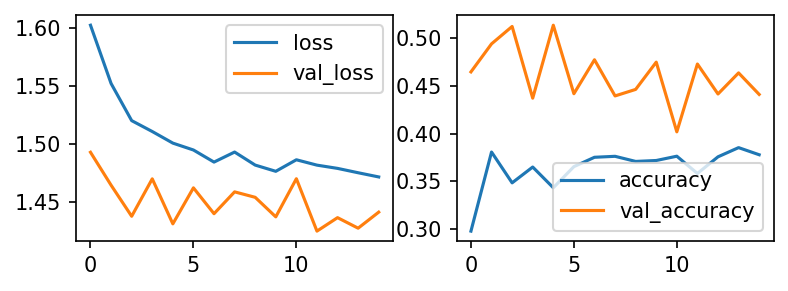

Epoch 1/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.5597 - cohen_kappa: 0.0203 - val_loss: 1.4841 - val_cohen_kappa: 0.0578
Epoch 2/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.5138 - cohen_kappa: 0.0332 - val_loss: 1.4750 - val_cohen_kappa: 0.0673
Epoch 3/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.4987 - cohen_kappa: 0.0417 - val_loss: 1.4543 - val_cohen_kappa: 0.0674
Epoch 4/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.4916 - cohen_kappa: 0.0441 - val_loss: 1.4744 - val_cohen_kappa: 0.0615
Epoch 5/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.4840 - cohen_kappa: 0.0476 - val_loss: 1.4567 - val_cohen_kappa: 0.0696
Epoch 6/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.4833 - cohen_kappa: 0.0524 - val_loss: 1.4614 - val_cohen_kappa: 0.0711
Epoch 7/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.4752 - cohen_kappa: 0.

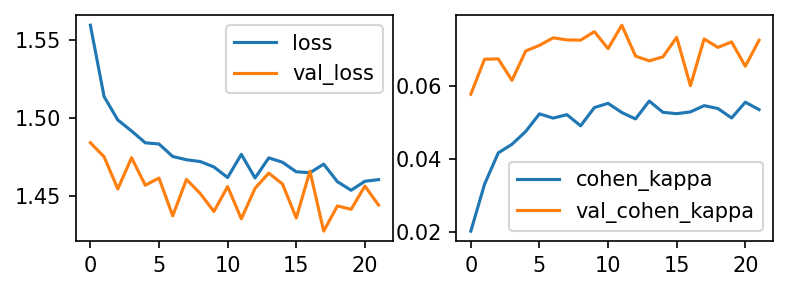

Epoch 1/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5863 - f1_score: 0.0946 - val_loss: 1.5271 - val_f1_score: 0.0958
Epoch 2/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5472 - f1_score: 0.1080 - val_loss: 1.4731 - val_f1_score: 0.1056
Epoch 3/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.5047 - f1_score: 0.1111 - val_loss: 1.4408 - val_f1_score: 0.1099
Epoch 4/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4806 - f1_score: 0.1195 - val_loss: 1.4365 - val_f1_score: 0.1150
Epoch 5/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4854 - f1_score: 0.1251 - val_loss: 1.4335 - val_f1_score: 0.1187
Epoch 6/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4830 - f1_score: 0.1251 - val_loss: 1.4183 - val_f1_score: 0.1080
Epoch 7/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.4902 - f1_score: 0.1254 - val_loss: 1.4139 - val_f1_score:

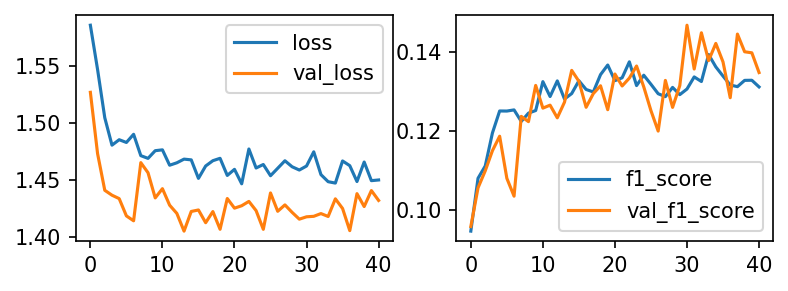

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.495679,0.416992,0.139227,0.352201,0.558824,0.469127,0.355323,0.412225,5.671
DT,0.832187,0.138184,0.077348,0.037736,0.147059,0.713534,0.137618,0.425576,1.216
RF,0.675541,0.272949,0.014365,0.339623,0.647059,0.597779,0.225421,0.411600,3.575
MLP accuracy,0.555738,0.358887,0.059669,0.477987,0.588235,0.510291,0.319822,0.415056,41.315
MLP cohen_kappa,0.504069,0.396973,0.107182,0.408805,0.617647,0.473022,0.352149,0.412585,67.996
MLP f1_score,0.471705,0.478516,0.089503,0.389937,0.588235,0.453756,0.341342,0.397549,119.137


In [ ]:
for name, metric in early_stop.items():
    model = create_mlp(metric)
    start = time.time()
    monitor = model.fit(X_train, y_train.values,
                    callbacks=[early_stops(name)],
                    class_weight = cls_wgt,
                    validation_data=(X_val, y_val.values),
                    verbose=1, epochs=50)
    end = time.time()
    rsts = rsts.append(evaluation(model, monitor, end - start,  'MLP '+ name))
rsts

# One-hot encoded multiclass


In [ ]:
 early_stop = {'auc':       tf.keras.metrics.AUC(name='auc'),
     'accuracy':  tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
               'precision': tf.keras.metrics.Precision(name='precision'),
               'recall':    tf.keras.metrics.Recall(name='recall'),
               
               }

In [ ]:
def create_mlp(metric):
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1]
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[metric]
               )
    return MLP

Epoch 1/50
1900/1900 [==============================] - 4s 2ms/step - loss: 1.1416 - auc: 0.8974 - val_loss: 1.0705 - val_auc: 0.8969
Epoch 2/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0765 - auc: 0.8979 - val_loss: 1.0704 - val_auc: 0.8966
Epoch 3/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0723 - auc: 0.8973 - val_loss: 1.0704 - val_auc: 0.8966
Epoch 4/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0712 - auc: 0.8972 - val_loss: 1.0704 - val_auc: 0.8967
Epoch 5/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0707 - auc: 0.8972 - val_loss: 1.0704 - val_auc: 0.8968
Epoch 6/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0705 - auc: 0.8971 - val_loss: 1.0704 - val_auc: 0.8968
Epoch 7/50
1900/1900 [==============================] - 3s 2ms/step - loss: 1.0704 - auc: 0.8967 - val_loss: 1.0704 - val_auc: 0.8968
Epoch 8/50
1900/1900 [==============================] - 4s 2ms

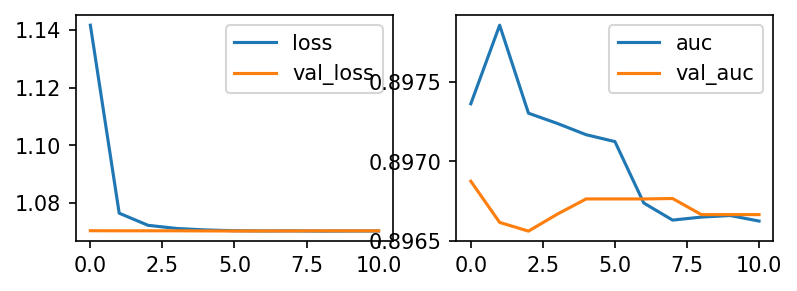

Epoch 1/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.1448 - accuracy: 0.8128 - val_loss: 1.0705 - val_accuracy: 0.8344
Epoch 2/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.0758 - accuracy: 0.8344 - val_loss: 1.0705 - val_accuracy: 0.8344
Epoch 3/50
1900/1900 [==============================] - 3s 1ms/step - loss: 1.0724 - accuracy: 0.8344 - val_loss: 1.0705 - val_accuracy: 0.8344
Epoch 4/50
1432/1900 [=====================>........] - ETA: 0s - loss: 1.0717 - accuracy: 0.8340

In [ ]:
for name, metric in early_stop.items():
    model = create_mlp(metric)
    start = time.time()
    monitor = model.fit(X_train, pd.get_dummies(y_train).values,
                    callbacks=[early_stops(name)],
#                    class_weight = cls_wgt,
                    validation_data=(X_val, pd.get_dummies(y_val).values),
                    verbose=1, epochs=50)
    end = time.time()
    rsts = rsts.append(evaluation(model, monitor, end - start,  'MLP 1H '+ name))
rsts

# Resampling

## Oversampling


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss

In [ ]:
coka = CohenKappa(num_classes=5,sparse_labels=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


ros
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 0.51 seconds
Epoch 1/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4699 - cohen_kappa: 0.2563 - val_loss: 1.4329 - val_cohen_kappa: 0.0779
Epoch 2/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.4572 - cohen_kappa: 0.2725 - val_loss: 1.4340 - val_cohen_kappa: 0.0793
Epoch 3/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4560 - cohen_kappa: 0.2739 - val_loss: 1.4197 - val_cohen_kappa: 0.0794
Epoch 4/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4550 - cohen_kappa: 0.2746 - val_loss: 1.3992 - val_cohen_kappa: 0.0888
Epoch 5/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4549 - cohen_kappa: 0.2750 - val_loss: 1.3997 - val_cohen_kappa: 0.0906
Epoch 6/50
63405/63405 [==============================] - 78s 1ms/step - loss: 1.4550 - cohen_kappa: 0.2751 - 

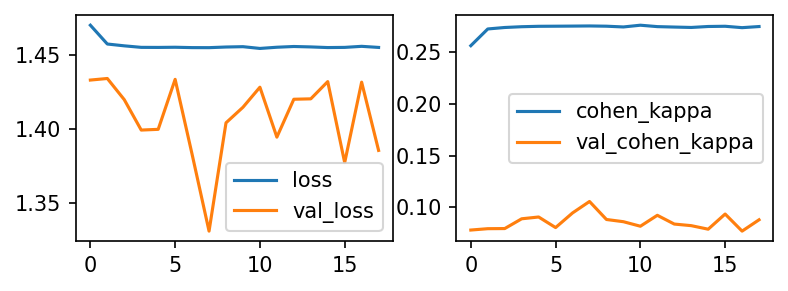

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

SMOTE
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 404.29 seconds
Epoch 1/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.4601 - cohen_kappa: 0.2662 - val_loss: 1.4067 - val_cohen_kappa: 0.0813
Epoch 2/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.4543 - cohen_kappa: 0.2731 - val_loss: 1.4063 - val_cohen_kappa: 0.0834
Epoch 3/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4531 - cohen_kappa: 0.2747 - val_loss: 1.4108 - val_cohen_kappa: 0.0792
Epoch 4/50
63405/63405 [==============================] - 88s 1ms/step - loss: 1.4526 - cohen_kappa: 0.2754 - val_loss: 1.3980 - val_cohen_kappa: 0.0869
Epoch 5/50
63405/63405 [==============================] - 83s 1ms/step - loss: 1.4523 - cohen_kappa: 0.2755 - val_loss: 1.4151 - val_cohen_kappa: 0.0832
Epoch 6/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.4522 - cohen_kappa: 0.276

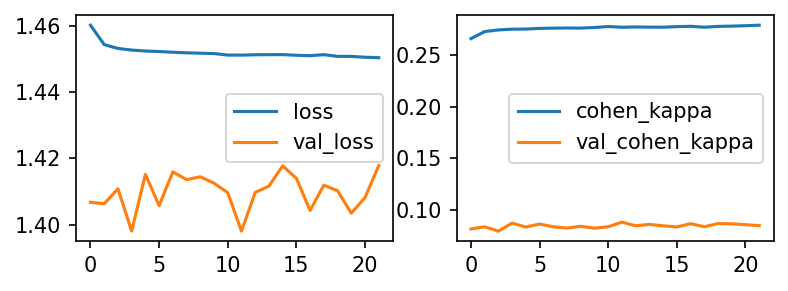

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

BorderlineSMOTE
Resampled dataset shape Counter({0: 405789, 1: 405789, 2: 405789, 3: 405789, 4: 405789})
resampling time is 9932.27 seconds
Epoch 1/50
63405/63405 [==============================] - 88s 1ms/step - loss: 1.3892 - cohen_kappa: 0.3748 - val_loss: 1.3523 - val_cohen_kappa: 0.0957
Epoch 2/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.3769 - cohen_kappa: 0.3912 - val_loss: 1.3432 - val_cohen_kappa: 0.1029
Epoch 3/50
63405/63405 [==============================] - 81s 1ms/step - loss: 1.3752 - cohen_kappa: 0.3935 - val_loss: 1.3334 - val_cohen_kappa: 0.1042
Epoch 4/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.3737 - cohen_kappa: 0.3960 - val_loss: 1.3526 - val_cohen_kappa: 0.1001
Epoch 5/50
63405/63405 [==============================] - 85s 1ms/step - loss: 1.3728 - cohen_kappa: 0.3970 - val_loss: 1.3473 - val_cohen_kappa: 0.1009
Epoch 6/50
63405/63405 [==============================] - 82s 1ms/step - loss: 1.3723 - cohen_k

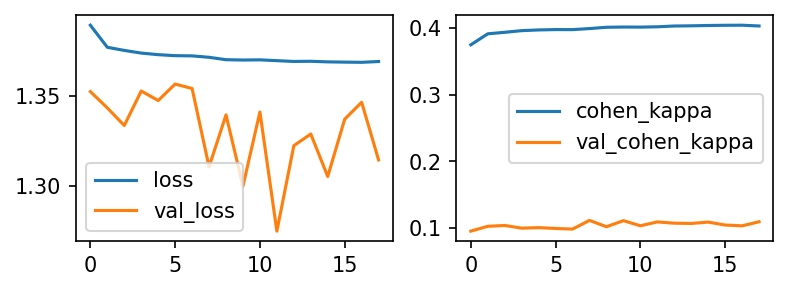

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


RUS
Resampled dataset shape Counter({0: 869, 1: 869, 2: 869, 3: 869, 4: 869})
resampling time is 0.22 seconds
Epoch 1/50
136/136 [==============================] - 4s 29ms/step - loss: 1.6256 - cohen_kappa: 0.0109 - val_loss: 1.5847 - val_cohen_kappa: 0.0135
Epoch 2/50
136/136 [==============================] - 4s 27ms/step - loss: 1.6034 - cohen_kappa: 0.0411 - val_loss: 1.5752 - val_cohen_kappa: 0.0222
Epoch 3/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5925 - cohen_kappa: 0.0791 - val_loss: 1.5399 - val_cohen_kappa: 0.0464
Epoch 4/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5722 - cohen_kappa: 0.1438 - val_loss: 1.5134 - val_cohen_kappa: 0.0577
Epoch 5/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5544 - cohen_kappa: 0.1732 - val_loss: 1.4734 - val_cohen_kappa: 0.0699
Epoch 6/50
136/136 [==============================] - 4s 27ms/step - loss: 1.5443 - cohen_kappa: 0.1787 - val_loss: 1.4561 - val_cohen_kappa: 0.0

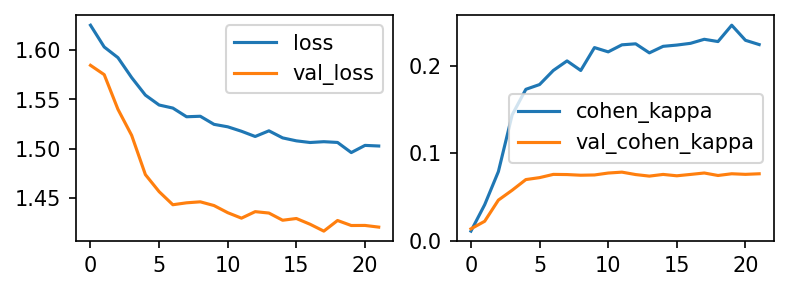

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

NearMiss
Resampled dataset shape Counter({0: 869, 1: 869, 2: 869, 3: 869, 4: 869})
resampling time is 33.98 seconds
Epoch 1/50
136/136 [==============================] - 5s 35ms/step - loss: 1.6088 - cohen_kappa: 0.0503 - val_loss: 1.5480 - val_cohen_kappa: 0.0217
Epoch 2/50
136/136 [==============================] - 4s 33ms/step - loss: 1.5241 - cohen_kappa: 0.1948 - val_loss: 1.5626 - val_cohen_kappa: 0.0285
Epoch 3/50
136/136 [==============================] - 4s 32ms/step - loss: 1.4934 - cohen_kappa: 0.2261 - val_loss: 1.5853 - val_cohen_kappa: 0.0274
Epoch 4/50
136/136 [==============================] - 5s 33ms/step - loss: 1.4814 - cohen_kappa: 0.2471 - val_loss: 1.5940 - val_cohen_kappa: 0.0275
Epoch 5/50
136/136 [==============================] - 4s 32ms/step - loss: 1.4685 - cohen_kappa: 0.2629 - val_loss: 1.6107 - val_cohen_kappa: 0.0248
Epoch 6/50
136/136 [==============================] - 4s 27ms/step - loss: 1.4640 - cohen_kappa: 0.2742 - val_loss: 1.6213 - val_cohen_kapp

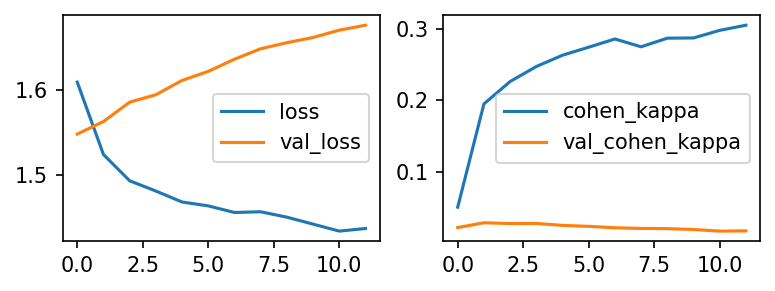

,Class 0,Class 1,Class 2,Class 3,Class 4,Overall Accuracy,G-mean,Avg_Pfm,Training Time
LR,0.513544,0.399548,0.137864,0.341981,0.634686,0.482139,0.361104,0.421621,33.938
DT,0.829026,0.142500,0.081641,0.063679,0.180812,0.711845,0.161846,0.436846,16.501
RF,0.634955,0.333394,0.028181,0.231132,0.738007,0.570343,0.252066,0.411205,43.834
MLP accuracy,0.547209,0.292506,0.212184,0.320755,0.605166,0.501997,0.366277,0.434137,416.384
MLP cohen_kappa,0.563730,0.310448,0.155961,0.420597,0.568266,0.515808,0.365509,0.440659,717.956
MLP f1_score,0.477529,0.492677,0.055394,0.281447,0.675277,0.457767,0.301149,0.379458,259.346
MLP with Cohen Kappa,0.477529,0.492677,0.055394,0.281447,0.675277,0.457767,0.301149,0.379458,259.346
MLP ros,0.673824,0.245209,0.128747,0.385220,0.579336,0.599064,0.342998,0.471031,1451.463
MLP SMOTE,0.490659,0.472782,0.115900,0.240566,0.726937,0.469209,0.342335,0.405772,2216.447
MLP BorderlineSMOTE,0.581441,0.415782,0.215638,0.335692,0.350554,0.543688,0.361042,0.452365,11417.054


In [ ]:
Resamples = {'ros':             RandomOverSampler(), 
             'SMOTE':           SMOTE(random_state=42),
             'BorderlineSMOTE': BorderlineSMOTE(),
             'RUS': RandomUnderSampler(), 
             'NearMiss': NearMiss()
             }
for key,value in Resamples.items():
    start = time.time()
    X_res, y_res = value.fit_resample(X_train, y_train)
    end = time.time()
    resampling_time = end - start
    print(key)
    print('Resampled dataset shape %s' % Counter(y_res))
    print('resampling time is {0:.2f} seconds'.format(end-start))
    model = create_mlp(CohenKappa(num_classes=5,sparse_labels=True))
    start = time.time()
    monitor = model.fit(X_res, y_res,
                        callbacks=[early_stops('cohen_kappa')],
                        validation_data=(X_val, y_val.values),
                        verbose=1, epochs=50)
    end = time.time()
    #print(evaluation(model, monitor, end - start, 'MLP '+key))
    rsts = rsts.append(evaluation(model, monitor, end - start + resampling_time, 'MLP '+key))
rsts